# Machine learning: DCGAN ---- Symbolist oil painting art


This project uses 1510 oil paintings in the Symbolic Art style as a dataset. As a contemporary abstract oil painting artist, I wanted to use machine learning methods to gain more inspiration for my artwork. Almost all art creators work from their own experiences and bring these to their work, but computers don't work like this, they don't have human experiences and emotions, so I created this art project to gain more inspiration from it.


In [ ]:
# Import the required PyTorch and other relevant libraries and set random seeds to obtain reproducible results.

In [1]:
import torch
from torch.nn import functional as F
from torch import nn 
from torch.optim import Adam
from torch.utils.data import DataLoader 
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np 
import random
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.auto import tqdm


%matplotlib inline 

# set seed for replicable results 
torch.manual_seed(999)
random.seed(10)

In [ ]:
#1.Define the path and associated parameters for the image dataset
#2.create image datasets.
#3.Creating data loaders.

In [28]:
image_path = "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/Symbolism_Resized"
image_size = (64, 64)
batch_size = 32
latent_size = 100
epoch_restore = 150
checkpoint_path = "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/checkpoint/150epochs.chkpt".format(epoch_restore)

lr = 0.001
beta1 = 0.5
epochs = 50



dataset = ImageFolder(root=image_path,
                           transform=T.Compose([
                               T.Resize(image_size),
                               T.ToTensor(),
                             
                               T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [ ]:
#Set the device to CPU and check if CUDA (GPU acceleration) is available

In [29]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

In [ ]:
#Get a batch of data from the data loader.

In [30]:
batch = next(iter(dataloader))

In [ ]:
#Displays images from the training dataset.

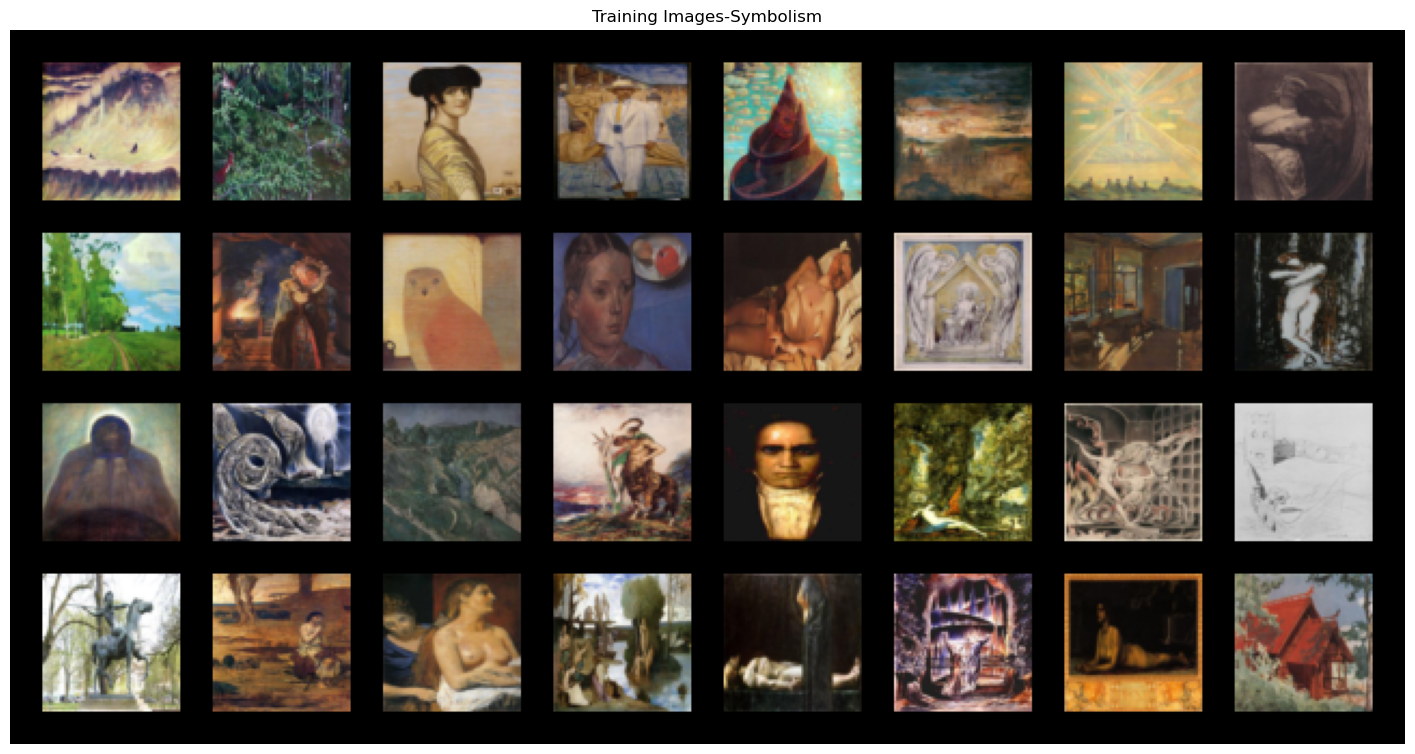

In [31]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images-Symbolism")

# viewing the training data 
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=15, normalize=True, nrow=8).cpu(),(1,2,0)))

In [ ]:
# Initializing the weights of a neural network model.

In [32]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
#Defining generators
#Submit it to the CPU

In [33]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(latent_size, 64*8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64*8)
        self.conv2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.conv4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))

In [34]:
generator = Generator().to(device)
generator.apply(weights_init)

# calculate the trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(generator)
print("Trainable Parameters:", count_parameters(generator))

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Trainable Parameters: 3576704


In [ ]:
#Set output size, batch size, number of channels

In [35]:
untrained_output = generator(torch.randn(1, 100, 1, 1, device=device))
print(untrained_output.shape)

torch.Size([1, 3, 64, 64])


In [ ]:
#Defining the discriminator

In [36]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64*2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64*2)
        self.conv3 = nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv4 = nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*8)
        self.conv5 = nn.Conv2d(64*8, 1, 4, 1, 0, bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        return torch.sigmoid(self.conv5(x))

In [ ]:
#Create discriminator models and print data

In [37]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

print(discriminator)
print("Trainable Parameters:", count_parameters(discriminator))

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
Trainable Parameters: 2765568


In [ ]:
#Discriminating the output of untrained generators,The output is flattened to a one-dimensional tensor

In [38]:
discriminator(untrained_output).view(-1).detach()

tensor([0.8848])

In [ ]:
#A sampled_noise sample of size batch_size is created, which will be used as input to the generator.

In [39]:
criterion = nn.BCELoss()
sampled_noise  = torch.randn(batch_size, latent_size, 1, 1, device=device)

# real is 1 and fake is 0
real_label = 1
fake_label = 0

generator_optim = Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
discriminator_optim = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
#Loaded dictionary of model parameters and optimiser states

In [40]:
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
generator_optim.load_state_dict(checkpoint['generator_optim_state_dict'])
discriminator_optim.load_state_dict(checkpoint['discriminator_optim_state_dict'])

In [ ]:
#Loaded dictionary of model parameters and optimiser states

In [41]:
generator_loss = []
discriminator_loss = [] 
iters = 0
img_list = []

In [ ]:
#Begain to training.
#Alternate training of discriminators and generators, optimising their parameters to improve the quality of the generated images

In [42]:
for epoch in range(epochs):
    for i, data in enumerate(tqdm(dataloader)):
        
        # train the discriminator 
        discriminator.zero_grad()
        real_data = data[0].to(device)
        real_size = real_data.size(0)
        
        # [1, 1, 1, 1...., 1]
        label = torch.ones(real_size, dtype=torch.float32, device=device)
        
        output = discriminator(real_data).view(-1)
        # loss on all-real batch
        error_real_batch = criterion(output, label)
        
        # calculate the derivative wrt parameters
        error_real_batch.backward()
        D_x = output.mean().item()
        
        # generating fake data
        noise = torch.randn(real_size, latent_size, 1, 1, device=device)
        fake_data = generator(noise)
        
        # change the label to [0, 0, 0, 0....., 0]
        label.fill_(fake_label)
        
        # classify all fake batch with discriminator 
        output = discriminator(fake_data.detach()).view(-1)
        error_fake_batch = criterion(output, label)
        error_fake_batch.backward()
        
        # the sum of the discriminator 
        error_discriminator = error_real_batch + error_fake_batch
        discriminator_optim.step()
        
        # train the generator 
        generator.zero_grad()
        # pretend the generated results are real 
        label.fill_(real_label)
        
        output = discriminator(fake_data).view(-1)
        error_generator = criterion(output, label)
        error_generator.backward()
        generator_optim.step()
        
        # print out summary statistics 
        if i % 10 == 0:
            tqdm.write('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     error_discriminator.item(), error_generator.item()))
            
        discriminator_loss.append(error_discriminator.item())
        generator_loss.append(error_generator.item())
        
         # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fakes = generator(sampled_noise).detach().cpu()
            img_list.append(vutils.make_grid(fakes, padding=2, normalize=True))

        iters += 1
    

  0%|          | 0/48 [00:03<?, ?it/s]

[0/50][0/48]	Loss_D: 4.9188	Loss_G: 0.0138
[0/50][10/48]	Loss_D: 2.5301	Loss_G: 13.2551
[0/50][20/48]	Loss_D: 1.3098	Loss_G: 5.0000
[0/50][30/48]	Loss_D: 2.0003	Loss_G: 8.0073
[0/50][40/48]	Loss_D: 2.6613	Loss_G: 2.3013


  0%|          | 0/48 [00:03<?, ?it/s]

[1/50][0/48]	Loss_D: 1.8117	Loss_G: 9.9490
[1/50][10/48]	Loss_D: 0.7655	Loss_G: 3.8533
[1/50][20/48]	Loss_D: 0.8781	Loss_G: 2.0137
[1/50][30/48]	Loss_D: 0.6574	Loss_G: 3.7814
[1/50][40/48]	Loss_D: 1.3848	Loss_G: 2.4575


  0%|          | 0/48 [00:03<?, ?it/s]

[2/50][0/48]	Loss_D: 2.6596	Loss_G: 10.5816
[2/50][10/48]	Loss_D: 1.0169	Loss_G: 1.8886
[2/50][20/48]	Loss_D: 1.1111	Loss_G: 3.2318
[2/50][30/48]	Loss_D: 0.5742	Loss_G: 2.7446
[2/50][40/48]	Loss_D: 1.7236	Loss_G: 7.5039


  0%|          | 0/48 [00:03<?, ?it/s]

[3/50][0/48]	Loss_D: 0.8670	Loss_G: 3.4993
[3/50][10/48]	Loss_D: 0.4378	Loss_G: 2.6551
[3/50][20/48]	Loss_D: 0.3671	Loss_G: 3.8247
[3/50][30/48]	Loss_D: 0.6783	Loss_G: 6.2244
[3/50][40/48]	Loss_D: 0.2864	Loss_G: 4.6907


  0%|          | 0/48 [00:03<?, ?it/s]

[4/50][0/48]	Loss_D: 0.6099	Loss_G: 2.1514
[4/50][10/48]	Loss_D: 0.2025	Loss_G: 5.1429
[4/50][20/48]	Loss_D: 0.3196	Loss_G: 4.0471
[4/50][30/48]	Loss_D: 1.3407	Loss_G: 6.7365
[4/50][40/48]	Loss_D: 2.7379	Loss_G: 8.5463


  0%|          | 0/48 [00:03<?, ?it/s]

[5/50][0/48]	Loss_D: 1.2863	Loss_G: 8.5730
[5/50][10/48]	Loss_D: 0.6442	Loss_G: 6.4553
[5/50][20/48]	Loss_D: 0.4505	Loss_G: 3.6267
[5/50][30/48]	Loss_D: 1.3197	Loss_G: 5.9777
[5/50][40/48]	Loss_D: 0.3079	Loss_G: 3.3800


  0%|          | 0/48 [00:04<?, ?it/s]

[6/50][0/48]	Loss_D: 0.7982	Loss_G: 6.8186
[6/50][10/48]	Loss_D: 0.6420	Loss_G: 3.4288
[6/50][20/48]	Loss_D: 0.3994	Loss_G: 4.1742
[6/50][30/48]	Loss_D: 0.4769	Loss_G: 3.8147
[6/50][40/48]	Loss_D: 0.1558	Loss_G: 5.0737


  0%|          | 0/48 [00:03<?, ?it/s]

[7/50][0/48]	Loss_D: 0.2430	Loss_G: 3.9581
[7/50][10/48]	Loss_D: 0.7055	Loss_G: 1.3653
[7/50][20/48]	Loss_D: 0.2152	Loss_G: 4.4698
[7/50][30/48]	Loss_D: 0.2986	Loss_G: 5.0467
[7/50][40/48]	Loss_D: 0.3708	Loss_G: 3.2934


  0%|          | 0/48 [00:03<?, ?it/s]

[8/50][0/48]	Loss_D: 4.2869	Loss_G: 8.0942
[8/50][10/48]	Loss_D: 1.1783	Loss_G: 4.5655
[8/50][20/48]	Loss_D: 0.8796	Loss_G: 3.3929
[8/50][30/48]	Loss_D: 0.2030	Loss_G: 4.9339
[8/50][40/48]	Loss_D: 0.2004	Loss_G: 5.2691


  0%|          | 0/48 [00:04<?, ?it/s]

[9/50][0/48]	Loss_D: 0.9424	Loss_G: 5.0528
[9/50][10/48]	Loss_D: 0.1879	Loss_G: 4.5114
[9/50][20/48]	Loss_D: 0.3759	Loss_G: 3.6029
[9/50][30/48]	Loss_D: 0.6786	Loss_G: 3.6249
[9/50][40/48]	Loss_D: 0.3932	Loss_G: 3.8267


  0%|          | 0/48 [00:03<?, ?it/s]

[10/50][0/48]	Loss_D: 0.2058	Loss_G: 4.2638
[10/50][10/48]	Loss_D: 0.4082	Loss_G: 3.3096
[10/50][20/48]	Loss_D: 0.4496	Loss_G: 4.9078
[10/50][30/48]	Loss_D: 0.6673	Loss_G: 3.2118
[10/50][40/48]	Loss_D: 0.1763	Loss_G: 4.2328


  0%|          | 0/48 [01:44<?, ?it/s]

[11/50][0/48]	Loss_D: 0.3760	Loss_G: 4.6584
[11/50][10/48]	Loss_D: 0.6712	Loss_G: 1.5405
[11/50][20/48]	Loss_D: 0.3302	Loss_G: 5.2577
[11/50][30/48]	Loss_D: 0.3193	Loss_G: 5.1608
[11/50][40/48]	Loss_D: 0.2292	Loss_G: 4.5246


  0%|          | 0/48 [00:04<?, ?it/s]

[12/50][0/48]	Loss_D: 0.1845	Loss_G: 4.4330
[12/50][10/48]	Loss_D: 0.4219	Loss_G: 2.8489
[12/50][20/48]	Loss_D: 0.7839	Loss_G: 1.6328
[12/50][30/48]	Loss_D: 0.4190	Loss_G: 4.2748
[12/50][40/48]	Loss_D: 0.8395	Loss_G: 2.8362


  0%|          | 0/48 [00:04<?, ?it/s]

[13/50][0/48]	Loss_D: 0.6848	Loss_G: 2.4627
[13/50][10/48]	Loss_D: 0.2289	Loss_G: 3.6365
[13/50][20/48]	Loss_D: 0.3293	Loss_G: 4.0173
[13/50][30/48]	Loss_D: 0.2992	Loss_G: 4.3456
[13/50][40/48]	Loss_D: 0.1628	Loss_G: 3.8889


  0%|          | 0/48 [00:04<?, ?it/s]

[14/50][0/48]	Loss_D: 1.8077	Loss_G: 8.5316
[14/50][10/48]	Loss_D: 0.2021	Loss_G: 4.9671
[14/50][20/48]	Loss_D: 0.4627	Loss_G: 3.2797
[14/50][30/48]	Loss_D: 0.5277	Loss_G: 3.3994
[14/50][40/48]	Loss_D: 0.3431	Loss_G: 3.6081


  0%|          | 0/48 [00:04<?, ?it/s]

[15/50][0/48]	Loss_D: 0.3436	Loss_G: 4.9941
[15/50][10/48]	Loss_D: 0.1585	Loss_G: 5.6968
[15/50][20/48]	Loss_D: 0.2960	Loss_G: 5.5530
[15/50][30/48]	Loss_D: 0.2932	Loss_G: 4.8696
[15/50][40/48]	Loss_D: 0.2077	Loss_G: 4.4809


  0%|          | 0/48 [00:04<?, ?it/s]

[16/50][0/48]	Loss_D: 0.2191	Loss_G: 3.8763
[16/50][10/48]	Loss_D: 0.3510	Loss_G: 5.3014
[16/50][20/48]	Loss_D: 0.2157	Loss_G: 3.6572
[16/50][30/48]	Loss_D: 0.1216	Loss_G: 5.5572
[16/50][40/48]	Loss_D: 0.1110	Loss_G: 5.1174


  0%|          | 0/48 [00:03<?, ?it/s]

[17/50][0/48]	Loss_D: 0.1042	Loss_G: 5.5787
[17/50][10/48]	Loss_D: 0.2151	Loss_G: 4.5549
[17/50][20/48]	Loss_D: 0.2606	Loss_G: 5.1548
[17/50][30/48]	Loss_D: 0.1408	Loss_G: 4.4536
[17/50][40/48]	Loss_D: 0.1078	Loss_G: 5.0361


  0%|          | 0/48 [00:04<?, ?it/s]

[18/50][0/48]	Loss_D: 0.2865	Loss_G: 3.5347
[18/50][10/48]	Loss_D: 0.2212	Loss_G: 5.9272
[18/50][20/48]	Loss_D: 0.0761	Loss_G: 4.5239
[18/50][30/48]	Loss_D: 0.1010	Loss_G: 4.8052
[18/50][40/48]	Loss_D: 0.1845	Loss_G: 4.2668


  0%|          | 0/48 [00:04<?, ?it/s]

[19/50][0/48]	Loss_D: 0.2588	Loss_G: 4.3088
[19/50][10/48]	Loss_D: 0.1206	Loss_G: 6.6898
[19/50][20/48]	Loss_D: 0.1236	Loss_G: 4.5334
[19/50][30/48]	Loss_D: 0.6285	Loss_G: 1.8741
[19/50][40/48]	Loss_D: 0.4482	Loss_G: 4.1065


  0%|          | 0/48 [00:14<?, ?it/s]

[20/50][0/48]	Loss_D: 0.4381	Loss_G: 3.4371
[20/50][10/48]	Loss_D: 0.2558	Loss_G: 5.0343
[20/50][20/48]	Loss_D: 0.1499	Loss_G: 4.6124
[20/50][30/48]	Loss_D: 0.0869	Loss_G: 5.5413
[20/50][40/48]	Loss_D: 0.4610	Loss_G: 3.3865


  0%|          | 0/48 [00:04<?, ?it/s]

[21/50][0/48]	Loss_D: 0.0382	Loss_G: 5.5743
[21/50][10/48]	Loss_D: 0.1562	Loss_G: 4.7344
[21/50][20/48]	Loss_D: 0.0825	Loss_G: 5.4942
[21/50][30/48]	Loss_D: 0.0418	Loss_G: 4.9993
[21/50][40/48]	Loss_D: 0.1298	Loss_G: 4.3652


  0%|          | 0/48 [00:04<?, ?it/s]

[22/50][0/48]	Loss_D: 0.1254	Loss_G: 4.8269
[22/50][10/48]	Loss_D: 0.1793	Loss_G: 4.1735
[22/50][20/48]	Loss_D: 0.0476	Loss_G: 5.5988
[22/50][30/48]	Loss_D: 0.2132	Loss_G: 4.5308
[22/50][40/48]	Loss_D: 0.1948	Loss_G: 5.1587


  0%|          | 0/48 [00:04<?, ?it/s]

[23/50][0/48]	Loss_D: 0.1138	Loss_G: 4.5084
[23/50][10/48]	Loss_D: 0.2496	Loss_G: 3.4660
[23/50][20/48]	Loss_D: 0.1093	Loss_G: 6.8635
[23/50][30/48]	Loss_D: 0.1544	Loss_G: 4.4649
[23/50][40/48]	Loss_D: 0.1736	Loss_G: 4.8621


  0%|          | 0/48 [00:04<?, ?it/s]

[24/50][0/48]	Loss_D: 0.1046	Loss_G: 5.5811
[24/50][10/48]	Loss_D: 0.0789	Loss_G: 6.0113
[24/50][20/48]	Loss_D: 0.2482	Loss_G: 5.3766
[24/50][30/48]	Loss_D: 0.2138	Loss_G: 2.5462
[24/50][40/48]	Loss_D: 0.1041	Loss_G: 4.8604


  0%|          | 0/48 [00:04<?, ?it/s]

[25/50][0/48]	Loss_D: 0.2409	Loss_G: 6.1171
[25/50][10/48]	Loss_D: 0.0933	Loss_G: 7.0248
[25/50][20/48]	Loss_D: 0.1102	Loss_G: 5.6202
[25/50][30/48]	Loss_D: 0.2450	Loss_G: 3.2929
[25/50][40/48]	Loss_D: 0.0671	Loss_G: 5.4964


  0%|          | 0/48 [00:04<?, ?it/s]

[26/50][0/48]	Loss_D: 0.8893	Loss_G: 7.8996
[26/50][10/48]	Loss_D: 0.4319	Loss_G: 8.7908
[26/50][20/48]	Loss_D: 0.0904	Loss_G: 6.2529
[26/50][30/48]	Loss_D: 1.0253	Loss_G: 1.1758
[26/50][40/48]	Loss_D: 0.4089	Loss_G: 4.3348


  0%|          | 0/48 [00:04<?, ?it/s]

[27/50][0/48]	Loss_D: 1.0298	Loss_G: 9.4187
[27/50][10/48]	Loss_D: 0.0862	Loss_G: 4.6661
[27/50][20/48]	Loss_D: 0.2883	Loss_G: 6.7720
[27/50][30/48]	Loss_D: 0.0997	Loss_G: 5.7479
[27/50][40/48]	Loss_D: 0.2235	Loss_G: 5.1111


  0%|          | 0/48 [00:04<?, ?it/s]

[28/50][0/48]	Loss_D: 0.2560	Loss_G: 4.8008
[28/50][10/48]	Loss_D: 0.0464	Loss_G: 4.7100
[28/50][20/48]	Loss_D: 0.0608	Loss_G: 5.8242
[28/50][30/48]	Loss_D: 0.0788	Loss_G: 5.9534
[28/50][40/48]	Loss_D: 0.4136	Loss_G: 6.7092


  0%|          | 0/48 [00:04<?, ?it/s]

[29/50][0/48]	Loss_D: 0.0612	Loss_G: 5.1806
[29/50][10/48]	Loss_D: 0.7132	Loss_G: 8.0911
[29/50][20/48]	Loss_D: 0.1430	Loss_G: 5.6524
[29/50][30/48]	Loss_D: 0.2543	Loss_G: 4.3576
[29/50][40/48]	Loss_D: 0.1821	Loss_G: 5.5182


  0%|          | 0/48 [00:04<?, ?it/s]

[30/50][0/48]	Loss_D: 0.0631	Loss_G: 5.1522
[30/50][10/48]	Loss_D: 0.2087	Loss_G: 3.8424
[30/50][20/48]	Loss_D: 0.0545	Loss_G: 5.3976
[30/50][30/48]	Loss_D: 0.1060	Loss_G: 4.0082
[30/50][40/48]	Loss_D: 0.2030	Loss_G: 6.0101


  0%|          | 0/48 [00:04<?, ?it/s]

[31/50][0/48]	Loss_D: 3.1385	Loss_G: 12.4698
[31/50][10/48]	Loss_D: 0.4181	Loss_G: 7.3037
[31/50][20/48]	Loss_D: 0.8097	Loss_G: 7.8862
[31/50][30/48]	Loss_D: 0.4067	Loss_G: 5.5359
[31/50][40/48]	Loss_D: 0.3324	Loss_G: 4.4225


  0%|          | 0/48 [00:04<?, ?it/s]

[32/50][0/48]	Loss_D: 1.6099	Loss_G: 10.1557
[32/50][10/48]	Loss_D: 0.1908	Loss_G: 5.5111
[32/50][20/48]	Loss_D: 0.2272	Loss_G: 4.3830
[32/50][30/48]	Loss_D: 0.0819	Loss_G: 5.3100
[32/50][40/48]	Loss_D: 0.0790	Loss_G: 5.1123


  0%|          | 0/48 [00:04<?, ?it/s]

[33/50][0/48]	Loss_D: 2.4520	Loss_G: 10.8096
[33/50][10/48]	Loss_D: 0.1214	Loss_G: 5.5147
[33/50][20/48]	Loss_D: 0.1111	Loss_G: 4.8044
[33/50][30/48]	Loss_D: 0.3191	Loss_G: 7.0227
[33/50][40/48]	Loss_D: 0.2845	Loss_G: 5.0317


  0%|          | 0/48 [00:14<?, ?it/s]

[34/50][0/48]	Loss_D: 0.1599	Loss_G: 5.5754
[34/50][10/48]	Loss_D: 0.2368	Loss_G: 4.0576
[34/50][20/48]	Loss_D: 0.1511	Loss_G: 4.9682
[34/50][30/48]	Loss_D: 0.1721	Loss_G: 6.3390
[34/50][40/48]	Loss_D: 0.1212	Loss_G: 4.5349


  0%|          | 0/48 [00:04<?, ?it/s]

[35/50][0/48]	Loss_D: 0.0482	Loss_G: 5.3582
[35/50][10/48]	Loss_D: 0.0478	Loss_G: 5.2512
[35/50][20/48]	Loss_D: 0.1572	Loss_G: 5.0607
[35/50][30/48]	Loss_D: 0.1362	Loss_G: 4.8645
[35/50][40/48]	Loss_D: 0.0523	Loss_G: 5.0067


  0%|          | 0/48 [00:04<?, ?it/s]

[36/50][0/48]	Loss_D: 0.2818	Loss_G: 3.7745
[36/50][10/48]	Loss_D: 0.0719	Loss_G: 4.8764
[36/50][20/48]	Loss_D: 0.0789	Loss_G: 5.8042
[36/50][30/48]	Loss_D: 0.0549	Loss_G: 5.3910
[36/50][40/48]	Loss_D: 0.2711	Loss_G: 5.1923


  0%|          | 0/48 [00:04<?, ?it/s]

[37/50][0/48]	Loss_D: 0.0387	Loss_G: 4.9885
[37/50][10/48]	Loss_D: 0.1040	Loss_G: 5.6741
[37/50][20/48]	Loss_D: 0.1884	Loss_G: 3.7931
[37/50][30/48]	Loss_D: 0.0096	Loss_G: 6.7102
[37/50][40/48]	Loss_D: 0.0891	Loss_G: 5.8879


  0%|          | 0/48 [00:04<?, ?it/s]

[38/50][0/48]	Loss_D: 0.6294	Loss_G: 7.7244
[38/50][10/48]	Loss_D: 0.1483	Loss_G: 6.1357
[38/50][20/48]	Loss_D: 0.1212	Loss_G: 5.0369
[38/50][30/48]	Loss_D: 0.1167	Loss_G: 5.2217
[38/50][40/48]	Loss_D: 0.2635	Loss_G: 5.7841


  0%|          | 0/48 [00:04<?, ?it/s]

[39/50][0/48]	Loss_D: 0.1068	Loss_G: 5.0098
[39/50][10/48]	Loss_D: 0.1093	Loss_G: 5.1706
[39/50][20/48]	Loss_D: 0.0589	Loss_G: 4.8069
[39/50][30/48]	Loss_D: 0.0690	Loss_G: 5.1941
[39/50][40/48]	Loss_D: 0.2441	Loss_G: 2.2958


  0%|          | 0/48 [00:04<?, ?it/s]

[40/50][0/48]	Loss_D: 2.1787	Loss_G: 13.7904
[40/50][10/48]	Loss_D: 0.5958	Loss_G: 7.8094
[40/50][20/48]	Loss_D: 0.1092	Loss_G: 4.7193
[40/50][30/48]	Loss_D: 0.1963	Loss_G: 5.7053
[40/50][40/48]	Loss_D: 0.2247	Loss_G: 6.2283


  0%|          | 0/48 [00:04<?, ?it/s]

[41/50][0/48]	Loss_D: 0.2826	Loss_G: 7.1544
[41/50][10/48]	Loss_D: 0.0274	Loss_G: 6.4938
[41/50][20/48]	Loss_D: 0.1179	Loss_G: 5.0515
[41/50][30/48]	Loss_D: 0.1105	Loss_G: 4.4599
[41/50][40/48]	Loss_D: 0.1163	Loss_G: 5.7573


  0%|          | 0/48 [00:04<?, ?it/s]

[42/50][0/48]	Loss_D: 0.1818	Loss_G: 6.3954
[42/50][10/48]	Loss_D: 0.0602	Loss_G: 5.1915
[42/50][20/48]	Loss_D: 0.0549	Loss_G: 5.9169
[42/50][30/48]	Loss_D: 0.0536	Loss_G: 5.5798
[42/50][40/48]	Loss_D: 0.0731	Loss_G: 6.0043


  0%|          | 0/48 [00:04<?, ?it/s]

[43/50][0/48]	Loss_D: 0.0355	Loss_G: 5.5544
[43/50][10/48]	Loss_D: 0.0674	Loss_G: 5.4140
[43/50][20/48]	Loss_D: 0.0279	Loss_G: 5.9912
[43/50][30/48]	Loss_D: 0.0724	Loss_G: 5.3516
[43/50][40/48]	Loss_D: 0.0283	Loss_G: 5.3449


  0%|          | 0/48 [00:04<?, ?it/s]

[44/50][0/48]	Loss_D: 0.0602	Loss_G: 6.9299
[44/50][10/48]	Loss_D: 0.1025	Loss_G: 5.5265
[44/50][20/48]	Loss_D: 0.1229	Loss_G: 4.8028
[44/50][30/48]	Loss_D: 0.0487	Loss_G: 5.7205
[44/50][40/48]	Loss_D: 0.1511	Loss_G: 4.3572


  0%|          | 0/48 [00:04<?, ?it/s]

[45/50][0/48]	Loss_D: 1.4069	Loss_G: 8.0671
[45/50][10/48]	Loss_D: 0.2192	Loss_G: 7.5271
[45/50][20/48]	Loss_D: 0.1144	Loss_G: 6.5003
[45/50][30/48]	Loss_D: 0.1381	Loss_G: 5.1942
[45/50][40/48]	Loss_D: 0.1011	Loss_G: 4.8976


  0%|          | 0/48 [00:04<?, ?it/s]

[46/50][0/48]	Loss_D: 0.1706	Loss_G: 6.6272
[46/50][10/48]	Loss_D: 0.0447	Loss_G: 4.4411
[46/50][20/48]	Loss_D: 0.0528	Loss_G: 6.1444
[46/50][30/48]	Loss_D: 0.3281	Loss_G: 7.5840
[46/50][40/48]	Loss_D: 0.1138	Loss_G: 6.0126


  0%|          | 0/48 [00:04<?, ?it/s]

[47/50][0/48]	Loss_D: 0.4917	Loss_G: 7.5155
[47/50][10/48]	Loss_D: 0.4282	Loss_G: 9.7898
[47/50][20/48]	Loss_D: 0.0968	Loss_G: 5.6102
[47/50][30/48]	Loss_D: 0.0632	Loss_G: 4.3459
[47/50][40/48]	Loss_D: 0.8382	Loss_G: 3.5090


  0%|          | 0/48 [00:04<?, ?it/s]

[48/50][0/48]	Loss_D: 0.7568	Loss_G: 8.5883
[48/50][10/48]	Loss_D: 0.1988	Loss_G: 7.2136
[48/50][20/48]	Loss_D: 0.0474	Loss_G: 5.2537
[48/50][30/48]	Loss_D: 0.1882	Loss_G: 5.5203
[48/50][40/48]	Loss_D: 0.0471	Loss_G: 5.1857


  0%|          | 0/48 [00:04<?, ?it/s]

[49/50][0/48]	Loss_D: 0.0593	Loss_G: 5.6625
[49/50][10/48]	Loss_D: 0.0600	Loss_G: 6.0137
[49/50][20/48]	Loss_D: 0.1494	Loss_G: 5.1287
[49/50][30/48]	Loss_D: 0.2289	Loss_G: 6.7499
[49/50][40/48]	Loss_D: 0.0382	Loss_G: 5.4843


In [ ]:
#Plot the loss of the generator and discriminator with the number of training iterations.

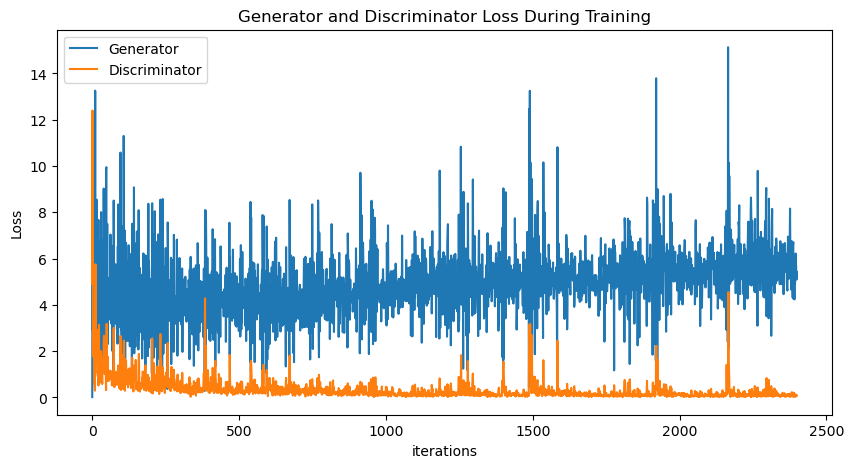

In [45]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss,label="Generator")
plt.plot(discriminator_loss,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#Create an animation showing a sample of images generated by the generator during the training process

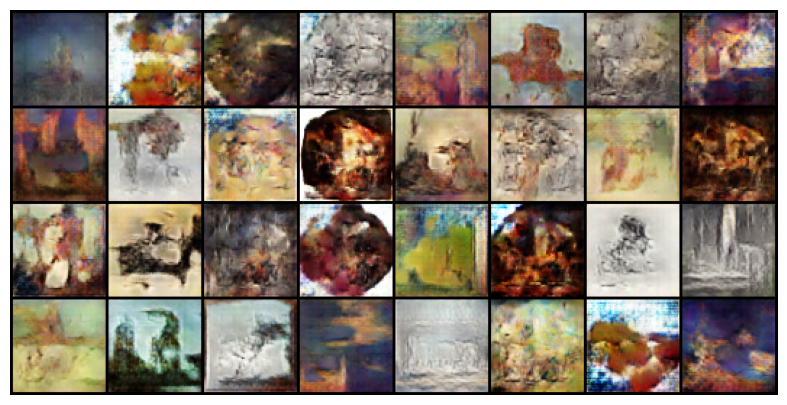

In [54]:
#%%capture
fig = plt.figure(figsize=(10,5))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=5000, repeat_delay=10000, blit=True)
ani.duration = 100000  # 设置动画的总持续时间为10秒


HTML(ani.to_jshtml())

In [ ]:
#Save the generator and discriminator models and optimiser state after training is complete.

In [55]:
end_epoch = epoch_restore + epochs
save_file = "{}epochs.chkpt".format(end_epoch)

torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'generator_optim_state_dict' : generator_optim.state_dict(),
            'discriminator_optim_state_dict' : discriminator_optim.state_dict(),}, save_file)

In [56]:
pip install imageio pillow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Generate a gif and set the gif save path

In [60]:
import imageio
from PIL import Image
import torchvision.transforms as transforms

def create_gif(image_list, save_path, duration=1):
    images = []
    for image in image_list:
        pil_image = transforms.ToPILImage()(image)
        images.append(pil_image)

    images[0].save(save_path, save_all=True, append_images=images[1:], duration=duration, loop=0, format='GIF')

image_list = img_list
save_path = "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/generated5_images.gif"

create_gif(image_list, save_path, duration=0.5)
